# <span style="color:blue"> Progetto di Machine Learning </span>

#### Luca Camillini - Settembre 2022

##  Reti neurali per la classificazione di tumori cerebrali

![tumors](Images/Tumors)
(Immagini presenti nel [dataset](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri) analizzato. Per ogni immagine è indicato il tipo di tumore)

Il tumore cerebrale consiste nella crescita anomala di cellule all'interno del tessuto nervoso. Sebbene si tratti di un tumore abbastanza raro (circa $1,6\%$ di tutti i tumori), quasi il 90$\%$ di essi riguarda lo sviluppo di cellule tumorali all'interno del sistema nervoso centrale, con gravi conseguenze fino alla morte. Esistono tre macro classi di tumore cerebrale:
- **glioma**: costituisce circa il $40\%$ dei tumori al sistema nervoso centrale e riguarda le cellule gliali che supportano il sistema nervoso,
- **meningioma**: compone circa il $15\%$ e ha origine nelle meningi, spesso diagnosticato per caso,
- **tumori dell'ipofisi**: riguardano, appunto, la ghiandola pituitaria e sono per lo più benigni.

(Fonte: [Humanitas](https://www.humanitas.it/malattie/tumori-cerebrali/))

Il metodo più efficace per osservare e classificare questi tumori è l'osservazione di immagini di risonanza magnetica della scatola cranica. In questo contesto, tecniche di machine learning possono dare un contributo importante nel processo di individuazione e classificazione dei tumori cerebrali: infatti, l'iter di individuazione della malattia parte dai primi sintomi e giunge alla diagnosi conclusiva solo a seguito di numerose analisi. Avere un sistema di intelligenza artificiale in grado di indirizzare fin da subito la ricerca della malattia può significare agilità e sicurezza nella diagnosi e, quindi, una maggior possibilità di agire sul paziente quando ancora la malattia non si trova all'ultimo stadio. Nel presente progetto svilupperemo delle reti aventi lo scopo di classificare i tipi di tumore, a partire da un dataset di immagini ottenute tramite risonanza magnetica.

Il notebook è così strutturato:
- presentazione del dataset,
- analisi del dataset tramite rete neurale di tipo *feed foreward* e *totalemente connessa* (FFNN), preceduta da riduzione dimensionale delle immagini per mezzo di analisi delle componenti principali (PCA),
- analisi del dataset tramite rete neurale *convoluzionale* (CNN),
- risultati e conclusioni.

## Dataset
Il dataset analizzato in questo progetto è stato scaricato dal seguente sito:

https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri

Esso è costituito da $3264$ immagini, ottenute tramite risonanza magnetica.

### Caricamento e  rimescolamento delle immagini

Il caricamento delle immagini è avvenuto sfruttando la libreria [**Pillow**](https://pypi.org/project/Pillow/). Per poter essere analizzate dalle reti di questo progetto è necessario che le immagini abbiano tutte la stessa dimensione e, per questo, al momento del caricamento vengono riscalate tramite la funzione [**resize**](https://pillow.readthedocs.io/en/stable/reference/Image.html#the-image-class), anch'essa contenuta nella libreria **Pillow**. In questo modo, il dataset è costituito da immagini $100\times100$ pixel, in scala di grigi. Di seguito è riassunta la classificazione avvenuta durante il caricamento

| Tipo di tumore      | Nome secondario  | Etichetta |
|:--------------------|:-----------------|-----------|
| Paziente sano       | No tumor         | $1,0,0,0$ |
| Glioma              | Glioma tumor     | $0,1,0,0$ |
| Meningioma          | Meningioma tumor | $0,0,1,0$ |
| Tumore dell'ipofisi | Pituitary tumor  | $0,0,0,1$ |

Il dataset online prevede già una suddivisione in campione di *training* e di *test*. Tuttavia, nel presente lavoro siamo interessati ad avere anche un campione di *validazione*; inoltre non sono fornite informazioni su come è avvenuta la divisione del campione e in quale percentuale. Per questo, durante il caricamento, viene creato un dataset unico. Dal momento che le immagini vengono caricate ed etichettate in maniera ordinata per tipologia (prima tutti i pazienti sani, poi i gliomi, ecc...), è stato necessario rimescolare gli elementi del dataset. Ciò è avvenuto facendo uso della funzione [**shuffle**](https://scikit-learn.org/stable/modules/generated/sklearn.utils.shuffle.html) presa dalle librerie di [**scikit-learn**](https://scikit-learn.org/stable/).

### Struttura del dataset

Una volta preparato il dataset completo, questo viene suddiviso in campione di *training* ($85\%$ delle immagini) e di *validazione* ($15\%$). La parte di *training* è stata ulteriormente suddivisa in una parte per l'allenamento in senso stretto ($85\%$) e in un campione di *test* ($15\%$). La suddivisione appena descritta è avvenuta tramite l'uso della funzione [**train_test_split()**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), contenuta nelle librerie di [**scikit-learn**](https://scikit-learn.org/stable/).

Di seguito è riportato il codice che implementa quanto presentato finora.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.axes import Axes
from sklearn import model_selection as ms
from sklearn import utils
from sklearn.decomposition import PCA
from PIL import Image
from tqdm import tqdm

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

%config InlineBackend.figure_format = 'retina'

In [2]:
#FUNCTIONS

def load_data(N, path, name, Name, X, Y, y):
    for i in range(N):
        file_name = path + str(i+1) + ').jpg'
        Name.append(name)
        img = Image.open(file_name)
        img = img.convert('L')
        img = img.resize((img_height,img_width))
        img = np.asarray(img)
        img = np.expand_dims(img, axis=-1)
        X.append(img)
        Y.append(y)
    return Name,X,Y

def cor_matrix(X, N, begin):
    x = np.reshape(X,(len(X), img_height*img_width))
    matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            x_i = pd.Series(x[begin+i])
            x_j = pd.Series(x[begin+j])
            matrix[i,j] = x_i.corr(x_j)
    return matrix

def graph_result(history):
    fig, ax = plt.subplots(1,2, figsize=(15,5))

    sns.set_theme(style='darkgrid')

    ax[0].plot(history.history['loss'], color='g', label='training')
    ax[0].plot(history.history['val_loss'], color='b', label='validation')
    ax[0].set_title('Cost functions', size=20)
    ax[0].set_xlabel('Epochs', size=15)
    ax[0].set_ylabel('Cost function', size=15)
    ax[0].legend(fontsize=12)

    ax[1].plot(history.history['acc'], color='g', label='training')
    ax[1].plot(history.history['val_acc'], color='b', label='validation')
    ax[1].set_title('Accuracies', size=20)
    ax[1].set_xlabel('Epochs', size=15)
    ax[1].set_ylabel('Accuracy', size=15)
    ax[1].legend(fontsize=12, loc=4)
    
def plot_predictions(X,Y,classes,predictions,scores):
    fig, ax = plt.subplots(2,5, figsize=(16,8))

    for i in range(10):
        index = np.random.randint(0,high=394)
        ax.flat[i].imshow(X[index], cmap='gray') 
        ax.flat[i].set_title("Class: {}\nPredicted:    {}".format(classes[np.argmax(Y[index])], 
                                                       classes[np.argmax(predictions[index])]))    
        ax.flat[i].axis('off') 
    plt.show()

    print('Loss function: ', '%.2f' %scores[0])
    print('Accuracy: ', '%.2f' %scores[1])

In [3]:
Names = []
X = []
Y = []

img_height, img_width = 100, 100

paths = ['Training/no_tumor/image(','Training/glioma_tumor/gg (','Training/meningioma_tumor/m (',
        'Training/meningioma_tumor/m1(','Training/meningioma_tumor/m2 (','Training/meningioma_tumor/m3 (',
        'Training/pituitary_tumor/p (','Testing/no_tumor/image(','Testing/glioma_tumor/image(',
         'Testing/meningioma_tumor/image(','Testing/pituitary_tumor/image(']
N_s = [395,826,200,199,177,246,827,105,100,115,74]
All_names = ['no tumor','glioma tumor','meningioma tumor','meningioma tumor',
         'meningioma tumor','meningioma tumor','pituitary tumor','no tumor','glioma tumor',
         'meningioma tumor','pituitary tumor']
y_s = [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,1,0],[0,0,1,0],[0,0,1,0],
       [0,0,0,1],[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]

for i in range(11):
    Names, X, Y = load_data(N_s[i], paths[i], All_names[i], Names, X, Y, y_s[i])
    
X = np.asarray(X)
Y = np.asarray(Y)

#shuffle
Names, X, Y = utils.shuffle(Names, X, Y, random_state=0)

#dividing train in train and validation
X_train, X_val, Y_train, Y_val, Names_train, Names_val = ms.train_test_split(X,Y,Names,
                                                                             train_size=0.85)
X_train, X_test, Y_train, Y_test, Names_train, Names_test = ms.train_test_split(X_train,Y_train, 
                                                                                Names_train,
                                                                                train_size=0.85)
X_test = np.asarray(X_test, dtype='float32')

## Caratteristiche del dataset

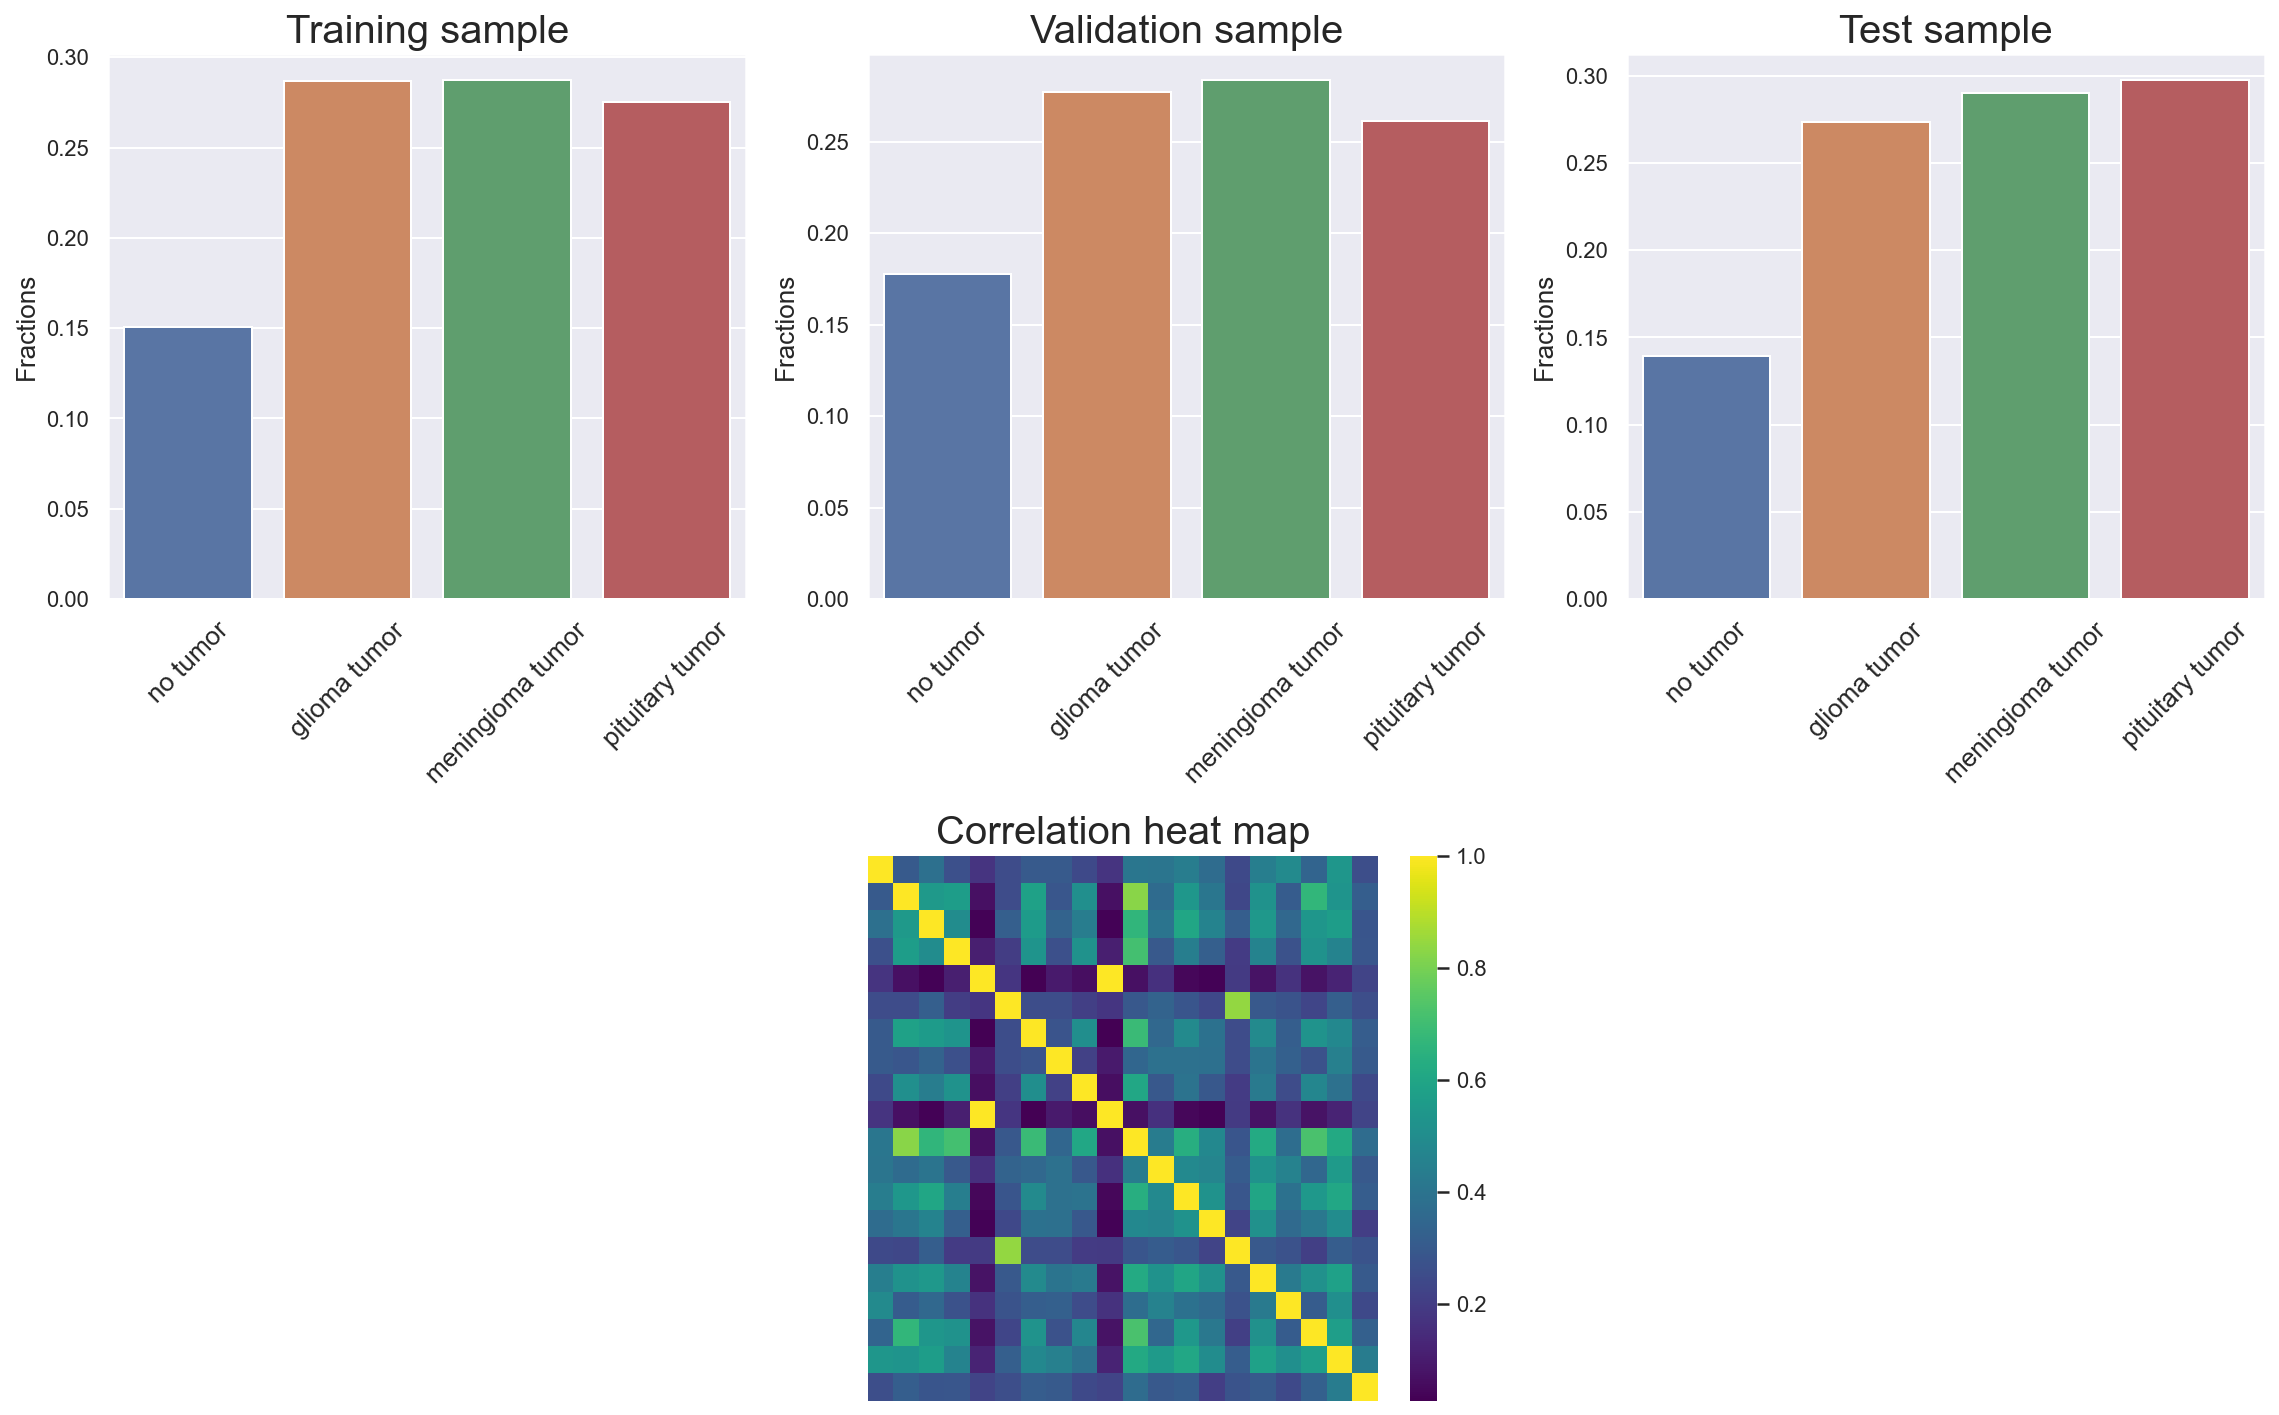


Train sample size:  2357
Validation sample size:  490
Test sample size:  417

Image size:  (100, 100, 1)


In [4]:
matrix = cor_matrix(X,20,1230)
counts = []
Names = [Names_train, Names_val, Names_test]
Titles = ['Training sample', 'Validation sample', 'Test sample']
classes = ['no tumor','glioma tumor','meningioma tumor','pituitary tumor']

for name in Names:
    counts.append([name.count('no tumor'), name.count('glioma tumor'), 
              name.count('meningioma tumor'),name.count('pituitary tumor')])

sns.set_theme(style='darkgrid')
fig, ax = plt.subplots(2,3, figsize=(16,10))
ax = np.reshape(ax, (6))

for i in range(3):
    sns.barplot(ax=ax[i], x=classes, y=counts[i]/np.sum(counts[i]))
    ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation = 45,size=13)
    ax[i].set_title(Titles[i],size=20)
    ax[i].set_ylabel('Fractions',size=13)

sns.heatmap(matrix, cmap='viridis', ax = ax[4])
ax[4].axis('off')
ax[4].set_title('Correlation heat map', size = 20)

ax[5].axis('off')
ax[3].axis('off')

plt.tight_layout()
plt.show()

print()

print('Train sample size: ', X_train.shape[0])
print('Validation sample size: ', X_val.shape[0])
print('Test sample size: ', X_test.shape[0])

print()

print('Image size: ', X_train[0].shape)

I tre istogrammi riportati in figura mostrano la distribuzione delle classi nei tre campioni; è possibile osservare che i pazienti sani sono meno di quelli malati e che le tre distribuzioni sono simili. La mancanza di immagini di pazienti sani può essere un problema in quanto le reti risulteranno più allenate nel riconoscere pazienti malati. Al tempo stesso, il fatto che i tre dataset siano strutturati in maniera simile rende le reti più performanti nel momento in cui verrà valutato il campione di test.

In secondo luogo è riportata una mappa di calore di correlazione tra $20$ elementi del dataset completo; osserviamo che alcune immagini risultano essere correlate. Ciò accade in quanto sono immagini dello stesso paziente e raffigurano strati diversi del cervello in cui è presente il tumore. Sarà necessario tenere conto di questa caratteristica durante l'allenamento delle reti.

Infine sono riportate le dimensioni dei campioni e delle immagini, il che mostra che il caricamento è avvenuto correttamente.

## Riduzione dimensionale delle immagini

Per poter trattare in maniera più agile l'analisi di queste immagini si è ricorso a una loro riduzione dimensionale, tramite l'analisi delle componenti principali.

### Analisi delle componenti principali (PCA)

La PCA è uno degli algoritmi di riduzione dati più utilizzati. L'idea su cui si basa è quella di individuare un iperpiano nello spazio delle *features* e di proiettare queste ultime su tale iperpiano, riducendo la dimensione dello spazio delle *features*.

Nel presente lavoro un'immagine può essere riscritta come un vettore che vive un uno spazio di $100\times100=10000$ componenti. Andando a scomporre la matrice di design $X_{design}$ tramite *Singular Value Decomposition* (SVD) si ottiene

$$
X_{design} = U\Sigma V
$$

dove
- $X_{design} \in Mat_{n\times p}(\mathbb R)$ rappresenta la matrice di design centrata nel valor medio del dataset,


- $U \in Mat_{n\times n}(\mathbb R)$ tale che $U^{-1} = U^{T}$,


- $\Sigma \in Mat_{n\times p}(\mathbb R)$ del tipo $\Sigma_{i,i}=\sigma_{i}$ e $0$ altrove,


- $V \in Mat_{p\times p}(\mathbb R)$ tale che $V^{-1} = V^{T}$.


Questo tipo di scomposizione è particolarmente interessante perché le colonne di $V$ sono i vettori che individuano le direzioni lungo cui i dati sono distribuiti con varianza $\sigma_{i}^{2}$. 

Nel scegliere l'iperpiano su cui proiettare le *features* si vuole ridurre il meno possibile la varianza del dataset, in quanto in essa è contenuta l'informazione. Allora, tramite SVD, andiamo a scegliere i primi $d$ vettori della matrice $V$ che hanno varianza più grande, costruendo la matrice di proiezione $W_{d}$. Così possiamo passare da uno spazio di dimensione $n$ a uno di dimensione $d$, con $d<n$:

$$
X_{d-proj} = XW_{d}
$$

o, al contrario, tornare alla dimensione originale:

$$
X = X_{d-proj}W_{d}^{T}
$$

Da ultimo, notiamo che è buona norma proiettare su un iperpiano in grado di mantenere il $95\%$ della varianza originaria, altrimenti si perderebbe troppa informazione per poter fare un'analisi corretta del dataset.

### Implementazione della PCA

Per implementare l'algoritmo della PCA si è fatto uso dell'apposita classe di [**scikit-learn**](https://scikit-learn.org/stable/), [**decomposition**](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition). Dopo aver trasformato le immagini da matrici a vettori, viene invocata la funzione **fit** sulle features e viene creato un vettore che contiene le somme cumulative delle varianze sui diversi assi principali. In questo modo è possibile osservare quanti vettori principali sono necessari per ottenere il $95\%$ della varianza, evitando così di considerare troppi elementi (o troppi pochi).

In [5]:
x_train_new=np.reshape(X_train, (len(X_train), img_height*img_width))
x_test_new=np.reshape(X_test, (len(X_test), img_height*img_width))

pca = PCA()
pca.fit(x_train_new)
cumsum = np.cumsum(pca.explained_variance_ratio_)

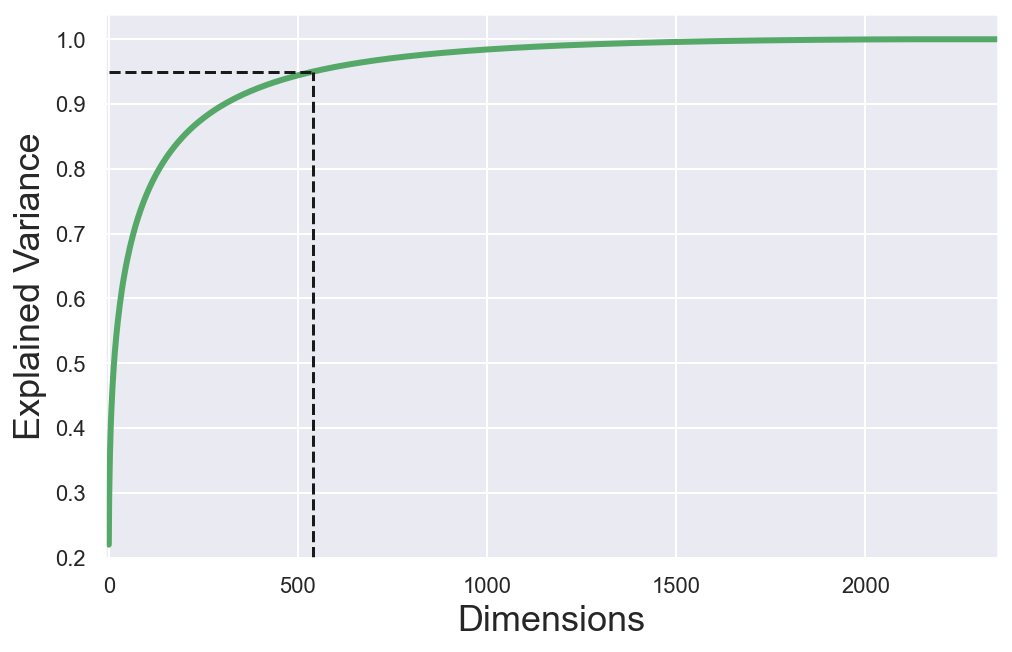

Dimenisone minima:  540


In [26]:
d = np.argmax(cumsum >= 0.95) + 1
sns.set_theme(style='darkgrid')

plt.figure(figsize=(8,5))
plt.plot(cumsum, color='g', linewidth=3)
plt.xlim(xmin=-10, xmax=2350)
plt.ylim(ymin=0.2)
plt.xlabel('Dimensions', size=18)
plt.ylabel('Explained Variance', size=18)
plt.hlines(0.95, xmin=0, xmax=d,color='k',linestyle='dashed')
plt.vlines(d, ymin=0, ymax=0.95,color='k',linestyle='dashed')
plt.show()
print('Dimenisone minima: ', d)

Il grafico riportato mostra la frazione di varianza mantenuta all'aumentare del numero di assi principali utilizzati. Per mantenere almeno il $95\%$ della varianza, è necessario proiettare le *features* in un iperpiano di dimensione superiore a $540$. 
Più avanti procederemo nell'analisi di immagini ridotte tramite PCA, tenendo le prime $600$ componenti. In questo modo viene conservata una varianza superiore al $95\%$ e lo spazio delle *features* è ridotto di un fattore superiore a $10$.

Da ultimo mostriamo come viene ricostruita l'immagine a seguito di PCA, variando il numero di assi principali. Come è possibile osservare, aumentando il numero di assi aumenta l'informazione che il processo di PCA conserva a seguito della riduzione e quindi la ricostruzione è più fedele all'immagine originaria.

In [7]:
x_train_new=np.reshape(X_train, (len(X_train), img_height*img_width))
x_test_new=np.reshape(X_test, (len(X_test), img_height*img_width))
y_train_new=np.argmax(Y_train, axis=-1)
y_test_new=np.argmax(Y_test, axis=-1)

pca_100 = PCA(100)
pca_250 = PCA(250)
pca_500 = PCA(500)
pca_600 = PCA(600)

pca_100.fit(x_train_new)
pca_250.fit(x_train_new)
pca_500.fit(x_train_new)
pca_600.fit(x_train_new)

pcas = [pca_100,pca_250,pca_500,pca_600] 

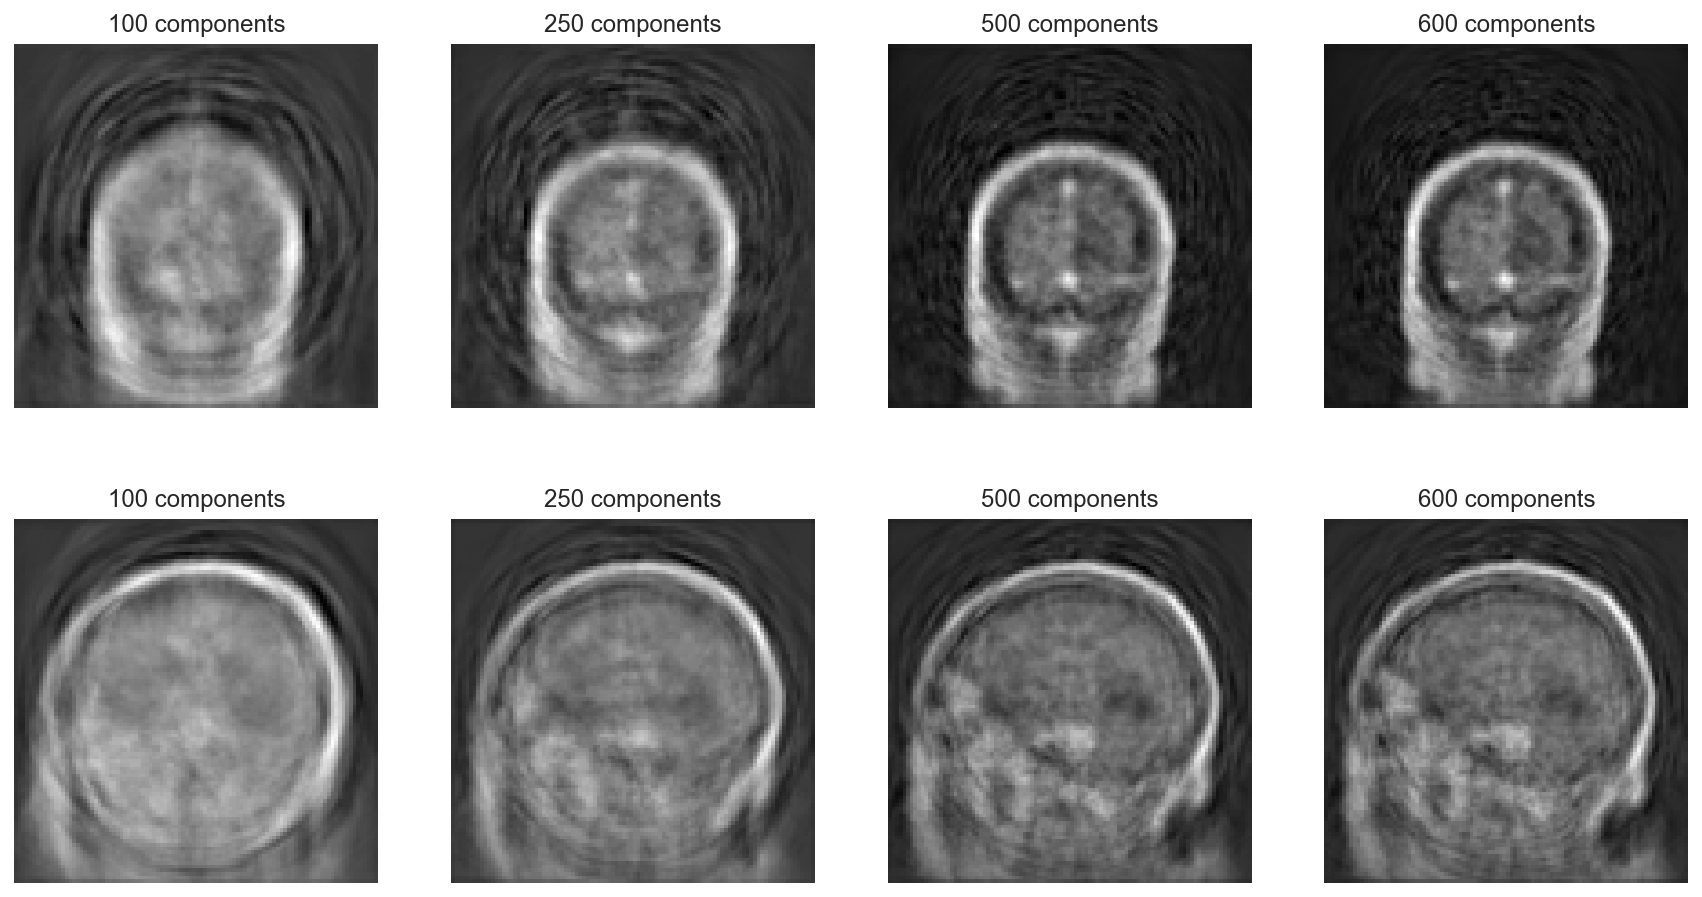

In [8]:
fig, ax =plt.subplots(2,4, figsize=(15,8))

numbers=[100,250,500,600]
for i,pca in enumerate(pcas):
    Z_train = pca.transform(x_train_new)
    Z_test = pca.transform(x_test_new)
    prova=pca.inverse_transform(Z_train[1500])
    first_image = np.array(prova, dtype='float')
    pixels = first_image.reshape((img_height,img_width))
    
    prova2=pca.inverse_transform(Z_test[300])
    second_image = np.array(prova2, dtype='float')
    pixels2 = second_image.reshape((img_height,img_width))
    
    ax.flat[i].imshow(pixels, cmap='gray')
    ax.flat[i+4].imshow(pixels2, cmap='gray')
    ax.flat[i+4].axis('off')
    ax.flat[i+4].set_title(str(numbers[i])+' components')
    ax.flat[i].axis('off')
    ax.flat[i].set_title(str(numbers[i])+' components')

## Rete neurale *feed foreward* (FFNN)

La prima rete implementata per la classificazione delle immagini è rete di tipo *feed foreward*, costruita attraverso le librerire di [Keras](https://keras.io/api/). Tutte le immagini sono state ridotte dimensionalmente tramite PCA, come descritto al punto precedente.

L'architettura utilizzata è molto semplice: dopo il primo layer di input seguono tre layer, i primi due con $200$ neuroni, il terzo con $40$; infine è presente il layer di output con $4$ neuroni per la classificazione. Di seguito sono elencate le caratteristiche della rete.

- I neuroni del primo e terzo layers nascosti vengono attivati tramite **ReLU**, il secondo layer nascosto tramite **sigmoide** e il layer di output tramite **softmax**. La scelta di inserire il sigmoide nel layer centrale è per mitigare l'effetto dovuto all'uso delle *ReLU* per il quale alcuni neuroni "muoiono": infatti, tale funzione di attivazione porta alcuni neuroni in uno stato in cui risultano inattivi. Se da un lato questo comporta un'ottimizzazione più rapida, al tempo stesso si facilita l'*overfitting* poiché la rete riesce a predire bene i dati di *training* senza essere performante sui dati di *test*. La presenza del sigmoide rallenta l'ottimizzazione ma permette di raggiungere una accuratezza più elevata riducendo lo spegnimento dei neuroni.
- Per ridurre ulteriormente il rischio di *overfitting* e per tenere conto della correlazione presente tra gli elementi del campione, nei layer nascosti è stato impostato il metodo di [**regolarizzazione $\ell_{2}$**](https://keras.io/api/layers/regularizers/), il quale consiste nell'aggiunta della somma dei quadrati dei pesi alla funzione di costo. Tramite tale regolarizzazione si diminuisce la varianza dei pesi della rete, prevenendo l'effetto per il quale il contributo di un dato con un certo peso viene cancellato dal contributo di un altro dato ad esso correlato e con peso di segno opposto. Si vuole prevenire tale effetto in quanto esso comporta una perdita di informazione nel processo di allenamento.
- È stata inserita anche una procedura di [**Dropout**](https://keras.io/api/layers/regularization_layers/dropout/) dopo il secondo layer nascosto con *rate* pari a $0.01$
- Per ottimizzare la rete si è fatto ricorso alla discesa stocastica del gradiente, [**SGD**](https://keras.io/api/optimizers/sgd/), con *learning rate* $\eta$ fissato. Come funzione di costo è stata utilizzata la [**cross-entropy**](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class).

### Impostazione dei parametri

La rete è stata allenata con diversi valori del *rate di apprendimento* $\eta$ e del coefficiente che moltiplica la somma dei quadrati dei pesi nel metodo di regolarizzazione, $\lambda$. Di seguito è riportata l'implementazione della rete e due mappe che riportano le prestazioni della rete allenata con questi diversi iperparametri.

La scelta della dimensione del *batch* è avvenuta cercando un compromesso tra la prestazione, che migliora diminuendo tale dimensione, e i tempi di allenamento.

In [9]:
#PCA
x_train_new=np.reshape(X_train, (len(X_train), img_height*img_width))
x_test_new=np.reshape(X_test, (len(X_test), img_height*img_width))
x_val_new=np.reshape(X_val, (len(X_val), img_height*img_width))

pca = PCA(600)
pca.fit(x_train_new)

x_train_new = pca.transform(x_train_new)
x_val_new = pca.transform(x_val_new)
x_test_new = pca.transform(x_test_new)

In [10]:
def create_FFNN(input_shape, n_classes, eta, lmbd):  
    model = Sequential()
    model.add(Dense(200, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(lmbd)))
    model.add(Dense(200, activation='sigmoid', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(Dropout(rate=0.01))
    model.add(Dense(40, activation='relu', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(Dense(n_classes, activation='softmax'))
    
    sgd = tf.keras.optimizers.SGD(lr=eta)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc'])
    
    return model

In [11]:
#Setting parameters
epochs = 80
batch_size = 10
input_shape = x_train_new[0].shape
n_classes = 4

eta_vals = np.logspace(-5, -3, 3)
lmbd_vals = np.logspace(-5, 0, 6)
train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
val_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

# grid search
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        DNN = create_FFNN(input_shape, n_classes,
                                         eta=eta, lmbd=lmbd)
        DNN.fit(x_train_new, Y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        train_accuracy[i][j] = DNN.evaluate(x_train_new, Y_train, verbose=0)[1]
        val_accuracy[i][j] = DNN.evaluate(x_val_new, Y_val, verbose=0)[1]

2022-09-11 09:01:22.053053: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-11 09:01:22.053607: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Text(0.5, 12.5, '$\\lambda$')

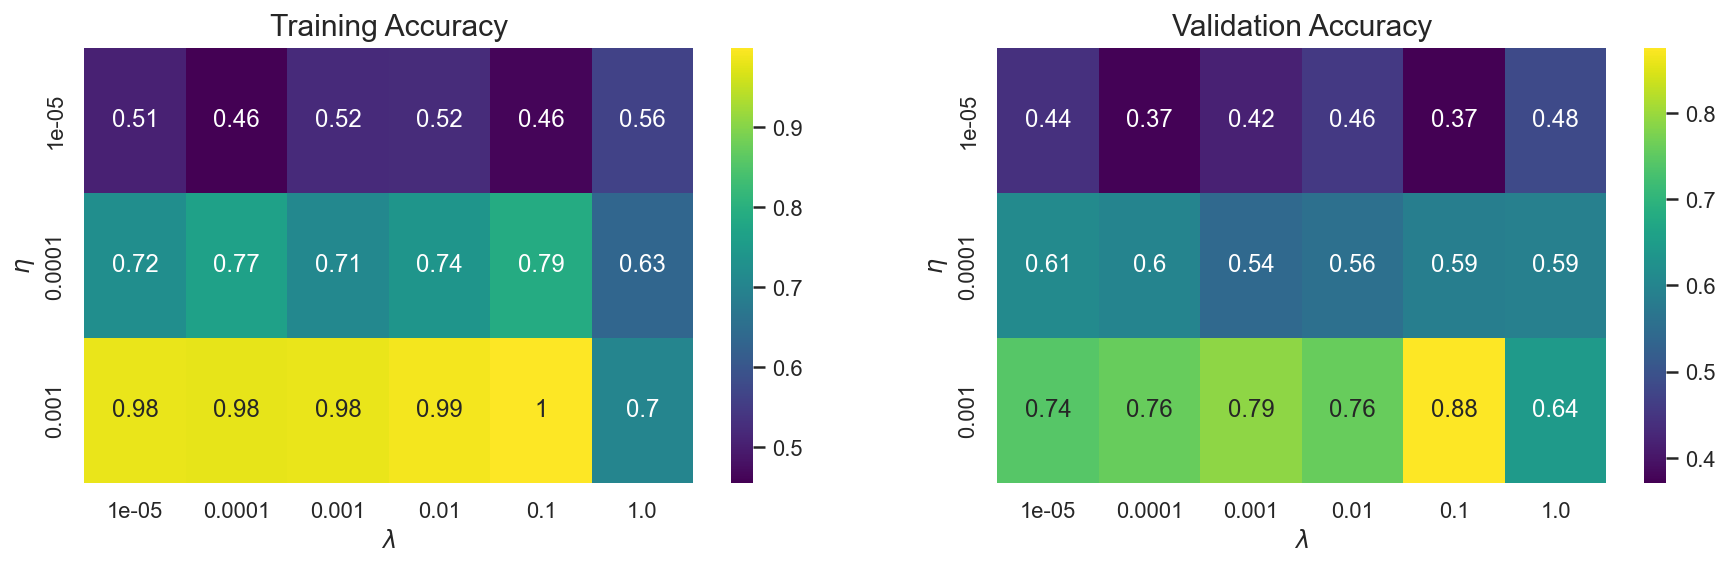

In [12]:
fig, ax = plt.subplots(1,2,figsize = (15, 4))
sns.heatmap(train_accuracy, annot=True, ax=ax[0], cmap="viridis", xticklabels=lmbd_vals, yticklabels=eta_vals)
ax[0].set_title("Training Accuracy",size=15)
ax[0].set_ylabel("$\eta$")
ax[0].set_xlabel("$\lambda$")

sns.heatmap(val_accuracy, annot=True, ax=ax[1], cmap="viridis", xticklabels=lmbd_vals, yticklabels=eta_vals)
ax[1].set_title("Validation Accuracy",size=15)
ax[1].set_ylabel("$\eta$")
ax[1].set_xlabel("$\lambda$")

Dalle mappe sopra riportate, scegliamo quei valori di $\lambda$ e $\eta$ che danno luogo alla migliore prestazione in termini di accuratezza sul campione di validazione.

Riassumendo, gli iperparametri sono impostati nel seguente modo:
- $\eta = 0.001$
- $\lambda = 0.1$
- *Dropout rate*: 0.01
- Numero di epoche: $80$
- Dimensione del batch: $10$

In [13]:
epochs = 80
batch_size = 10
input_shape = x_train_new[0].shape
n_classes = 4
eta = 0.001
lmbd = 0.1

DNN = create_FFNN(input_shape, n_classes, eta=eta, lmbd=lmbd)
DNN.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 200)               120200    
_________________________________________________________________
dense_73 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_18 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 40)                8040      
_________________________________________________________________
dense_75 (Dense)             (None, 4)                 164       
Total params: 168,604
Trainable params: 168,604
Non-trainable params: 0
_________________________________________________________________


In [14]:
history_DNN = DNN.fit(x_train_new, Y_train, 
                  epochs=epochs, 
                  batch_size=batch_size, 
                  verbose=0,
                  validation_data=(x_val_new, Y_val))

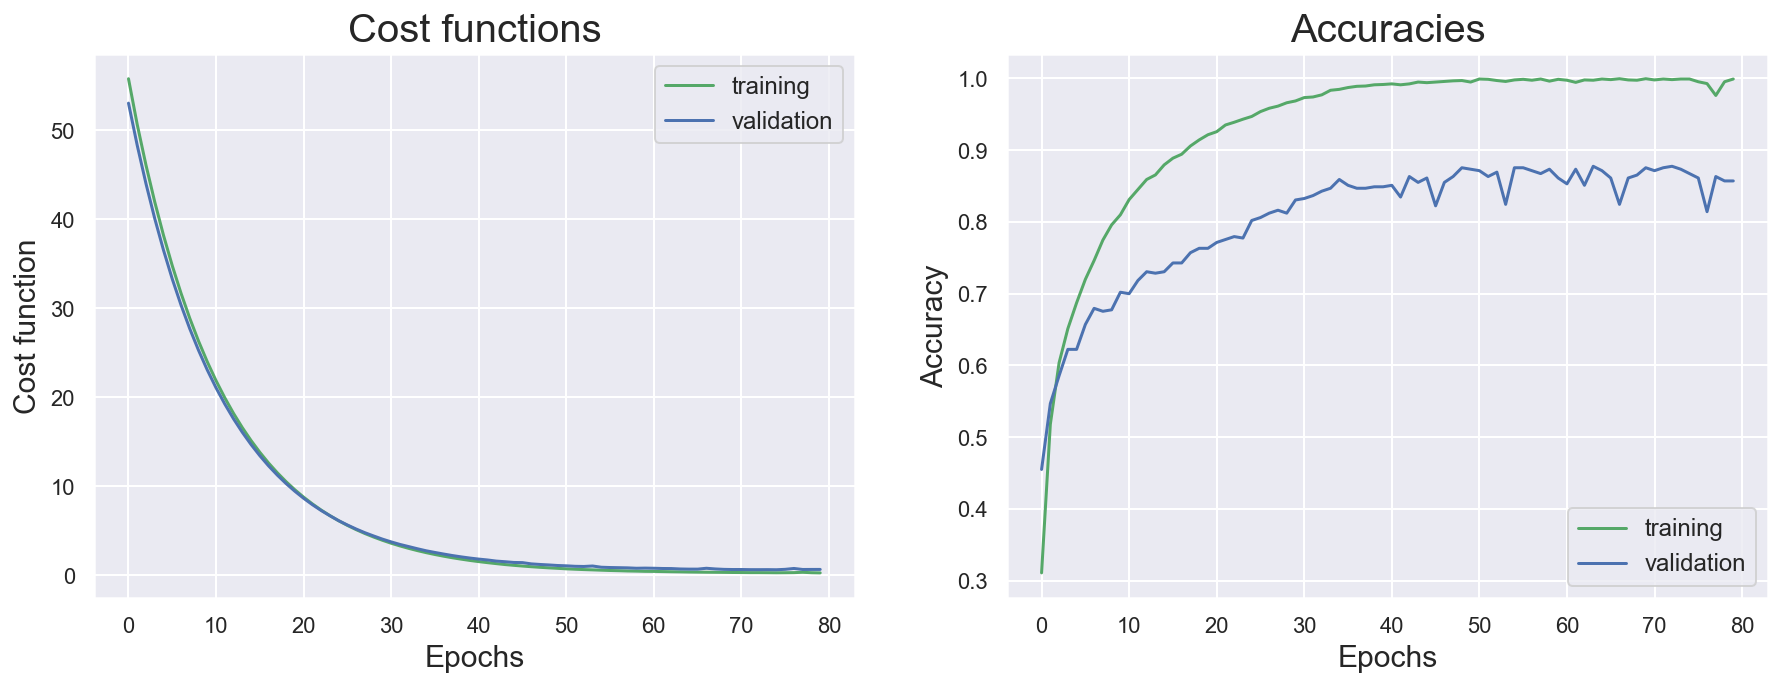

In [15]:
graph_result(history_DNN)

Dai grafici riportati osserviamo che l'apprendimento della rete avviene in maniera corretta, migliorando significativamente il valore della funzione di costo. Per quanto riguarda l'accuratezza osserviamo una discrepanza tra il campione di allenamento e di test. Ciò riteniamo sia dovuto a un problema di *overfitting* in quanto la rete si adatta molto bene al campione di allenamento, mentre non supera la soglia di $89\%$ di accuratezza sul campione di validazione. Tuttavia, è importante considerare anche che reti di questo tipo non sono le più efficienti nel trattare problemi di classificazione di immagini. Pertanto, essendo questi risultati i migliori ottenuti provando a variare sia l'architettura della rete sia i metodi di ottimizzazione, consideriamo questa rete come migliore in quanto abbiamo osservato in essa il compromesso più equilibrato tra *overfitting* e prestazione.


Infine proviamo la rete sul campione di test, mostriamo alcuni esempi confrontando il dato corretto con la predizione ottenuta e riportiamo i valori di funzione di costo e accuratezza.

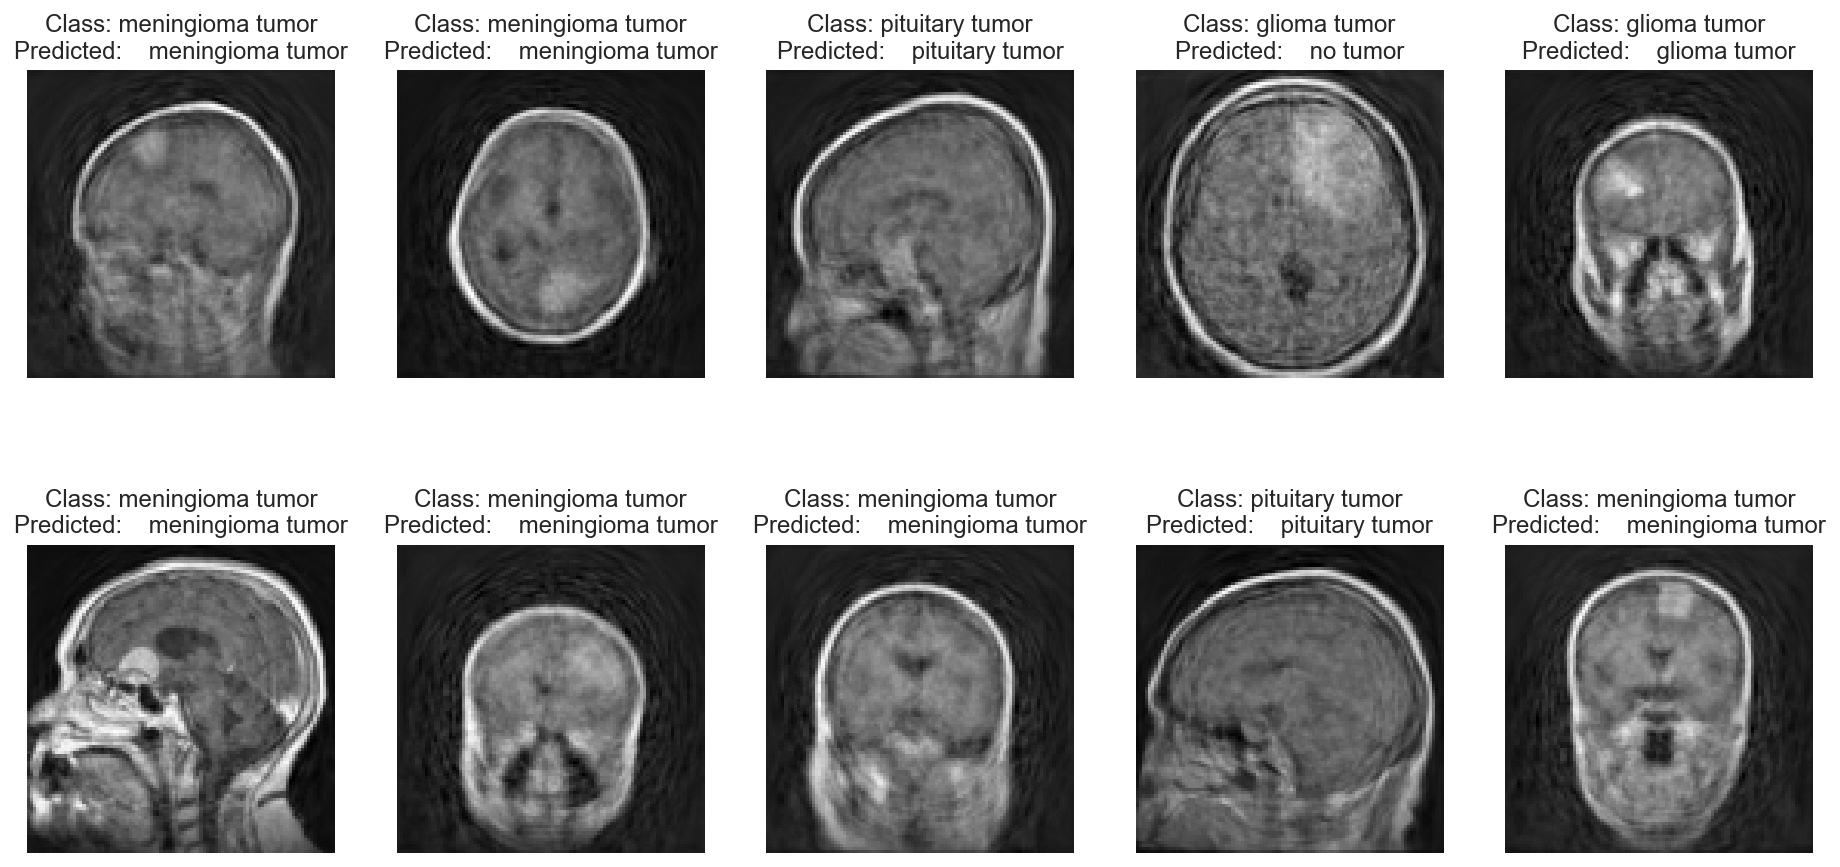

Loss function:  0.64
Accuracy:  0.87


In [16]:
scores = DNN.evaluate(x_test_new, Y_test, verbose=0)

predictions = DNN.predict(x_test_new)

x_test_new = pca.inverse_transform(x_test_new)
x_test_new = np.reshape(x_test_new,(x_test_new.shape[0], 100,100))

plot_predictions(x_test_new,Y_test,classes,predictions,scores)

## Rete neurale convoluzionale

Procediamo di seguito all'analisi dello stesso dataset, questa volta tramite una rete convoluzionale, usando sempre le librerie di *Keras*. Questo secondo approccio non richiede il trattamento della PCA, in quanto è la stessa rete a compiere un processo di semplificazione dell'immagine, per poi estrarne le informazioni in essa contenute. Il campione totale mantiene la stessa suddivisione in dataset di *training* ($2357$), *validazione* ($490$) e *test* ($417$).

L'architettura della rete è la seguente:
- Convoluzione: $16$ filtri $\left(3\times3\right)$ attivati tramite **ReLU**
- Max pooling di dimensione $\left(2\times2\right)$
- Convoluzione: $64$ filtri $\left(2\times2\right)$ attivati tramite **ReLU**
- Convoluzione: $64$ filtri $\left(2\times2\right)$ attivati tramite **sigmoide**
- Max pooling di dimensione $\left(3\times3\right)$
- Convoluzione: $64$ filtri $\left(2\times2\right)$ attivati tramite **tangente iperbolica**
- Max pooling di dimensione $\left(3\times3\right)$
- Strato di $200$ neuroni attivato tramite **ReLU**
- Dropout con *rate* pari a $0.5$
- Strato di $200$ neuroni attivato tramite **sigmoide**
- Dropout con *rate* pari a $0.1$
- Strato di $40$ neuroni attivato tramite **ReLU**
- Dropout con *rate* pari a $0.1$
- Strato di output con $4$ neuroni attivato tramite **softmax**

La rete è stata costruita cercando di usare filtri piccoli e numerosi. Come nel caso precedente, si è cercato un compromesso tra l'uso di **ReLU** e altri tipi di funzioni di attivazione per contrastare gli effetti negativi della prima senza perdere troppa efficienza; in particolare si è fatto uso del **sigmoide** e della **tangente iperbolica**. La parte finale della rete segue lo stesso tipo di struttura già implementato nel paragrafo precedente, con un uso maggiore di **dropout** su ogni layer.

L'algoritmo di ottimizzazione utilizzato è [**Nadam**](https://keras.io/api/optimizers/Nadam/), un tipo di algoritmo che sfrutta il suo parente **Adam** ma con l'aggiunta del *trucco di* ***Nesterov***. Questi tipi di algoritmi si basano sulla discesa del gradiente con l'aggiunta di una componente di *inerzia* calcolata in base alle caratteristiche del punto in cui ci si trova durante la discesa. In questo caso si è preferito usare **Nadam** invece che **Adam** in quanto il primo converge più velocemente del secondo, il che consente di allenare la rete per meno epoche, inizializzando l'algoritmo come indicato negli esempi riportati in Géron, Auriélien, *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow*, II ed. O'Reilly, 2019.

Di seguito i parametri impostati per l'allenamento:
- $\eta = 0.001$ 
- $\lambda = 0.001$
- Epoche: $34$
- Dimensione del batch: $10$

In [17]:
def create_CNN(input_shape, n_classes, lmbd, eta):
    model = Sequential()
    model.add(Conv2D(16,kernel_size=(3, 3), 
                     input_shape=input_shape, 
                     activation='relu',
                     kernel_regularizer=regularizers.l2(lmbd)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64,kernel_size=(2, 2), 
                     activation='relu',
                     kernel_regularizer=regularizers.l2(lmbd)))
    model.add(Conv2D(64,kernel_size=(2, 2), 
                     activation='sigmoid',
                     kernel_regularizer=regularizers.l2(lmbd)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Conv2D(64,kernel_size=(2, 2), 
                     activation='tanh',
                     kernel_regularizer=regularizers.l2(lmbd)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    
    model.add(Flatten())
    model.add(Dense(200, activation='relu',kernel_regularizer=regularizers.l2(lmbd)))
    model.add(Dropout(0.5))
    model.add(Dense(200, activation='sigmoid',kernel_regularizer=regularizers.l2(lmbd)))
    model.add(Dropout(0.1))
    model.add(Dense(40, activation='relu',kernel_regularizer=regularizers.l2(lmbd)))
    model.add(Dropout(0.1))
    model.add(Dense(n_classes, activation='softmax'))
    
    Adam = tf.keras.optimizers.Nadam(lr=eta, beta_1=0.9, beta_2=0.999)
    model.compile(loss='categorical_crossentropy', optimizer=Adam, metrics=['acc'])
    
    return model

In [22]:
epochs = 34
batch_size = 10
input_shape = X_train.shape[1:4]
n_classes = 4
eta = 0.001
lmbd = 0.001

model_CNN=create_CNN(input_shape, n_classes, lmbd, eta)
model_CNN.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 98, 98, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 48, 48, 64)        4160      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 47, 47, 64)        16448     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        16448     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 64)        

In [23]:
# train CNN
history_CNN = model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_val, Y_val))

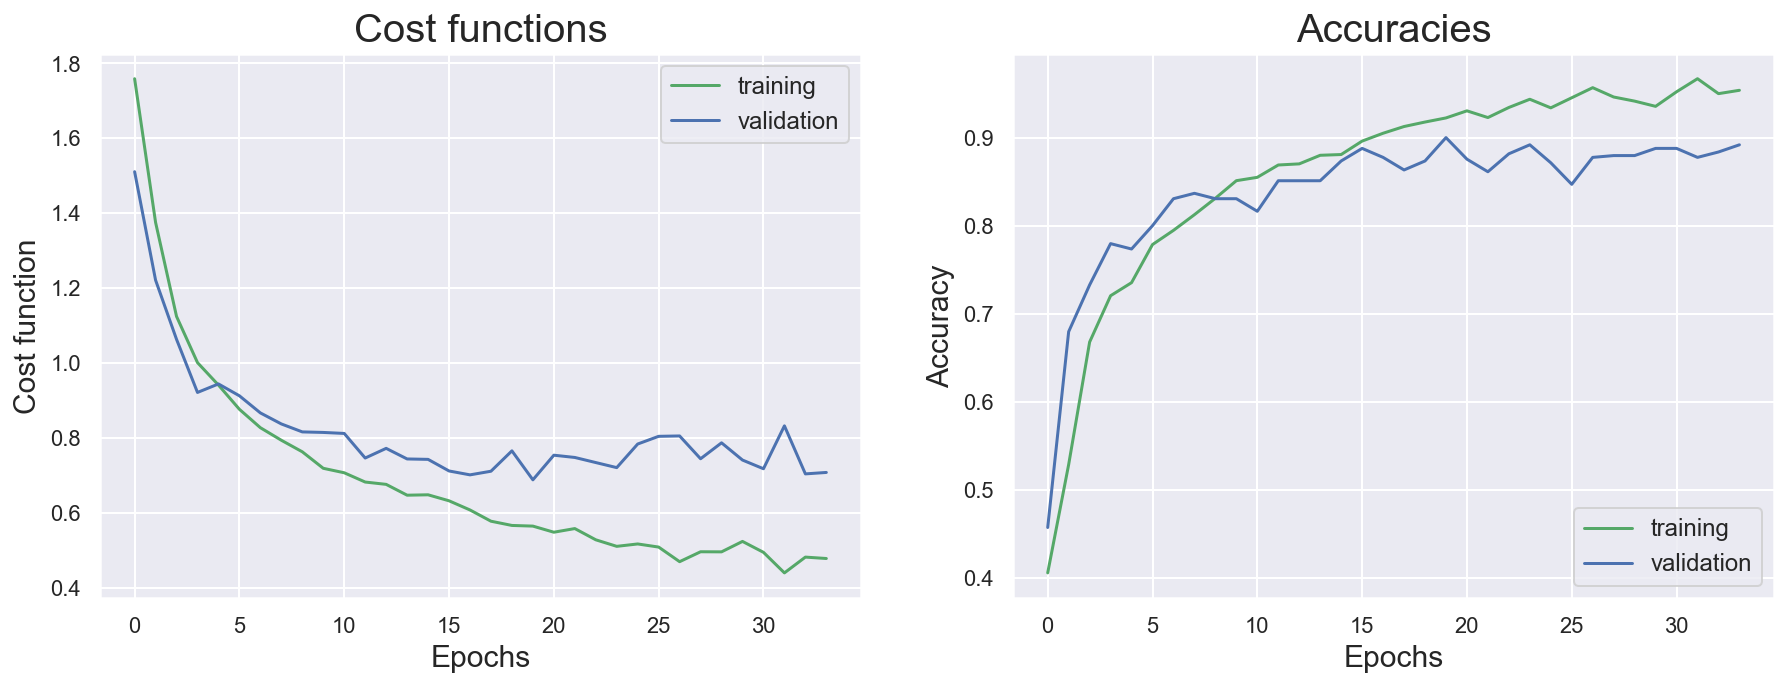

In [24]:
graph_result(history_CNN)

Dai grafici possiamo osservare che la rete è in grado di apprendere a riconoscere i tumori in $25-30$ epoche. Epoche ulteriori migliorano di poco la prestazione. Come è possibile aspettarsi, funzione di costo e accuratezza sul campione di allenamento raggiungo rispettivamente valori più bassi e più alti se confrontati con quelli ottenuti dal campione di validazione. L'andamento dell'accuratezza di validazione che segue quella di allenamento è segno che il modello utilizzato non sta facendo *overfitting*.

Infine riportiamo esempi casuali dal campione di test le prestazioni della rete su tale campione in termini di funzione di costo e accuratezza.

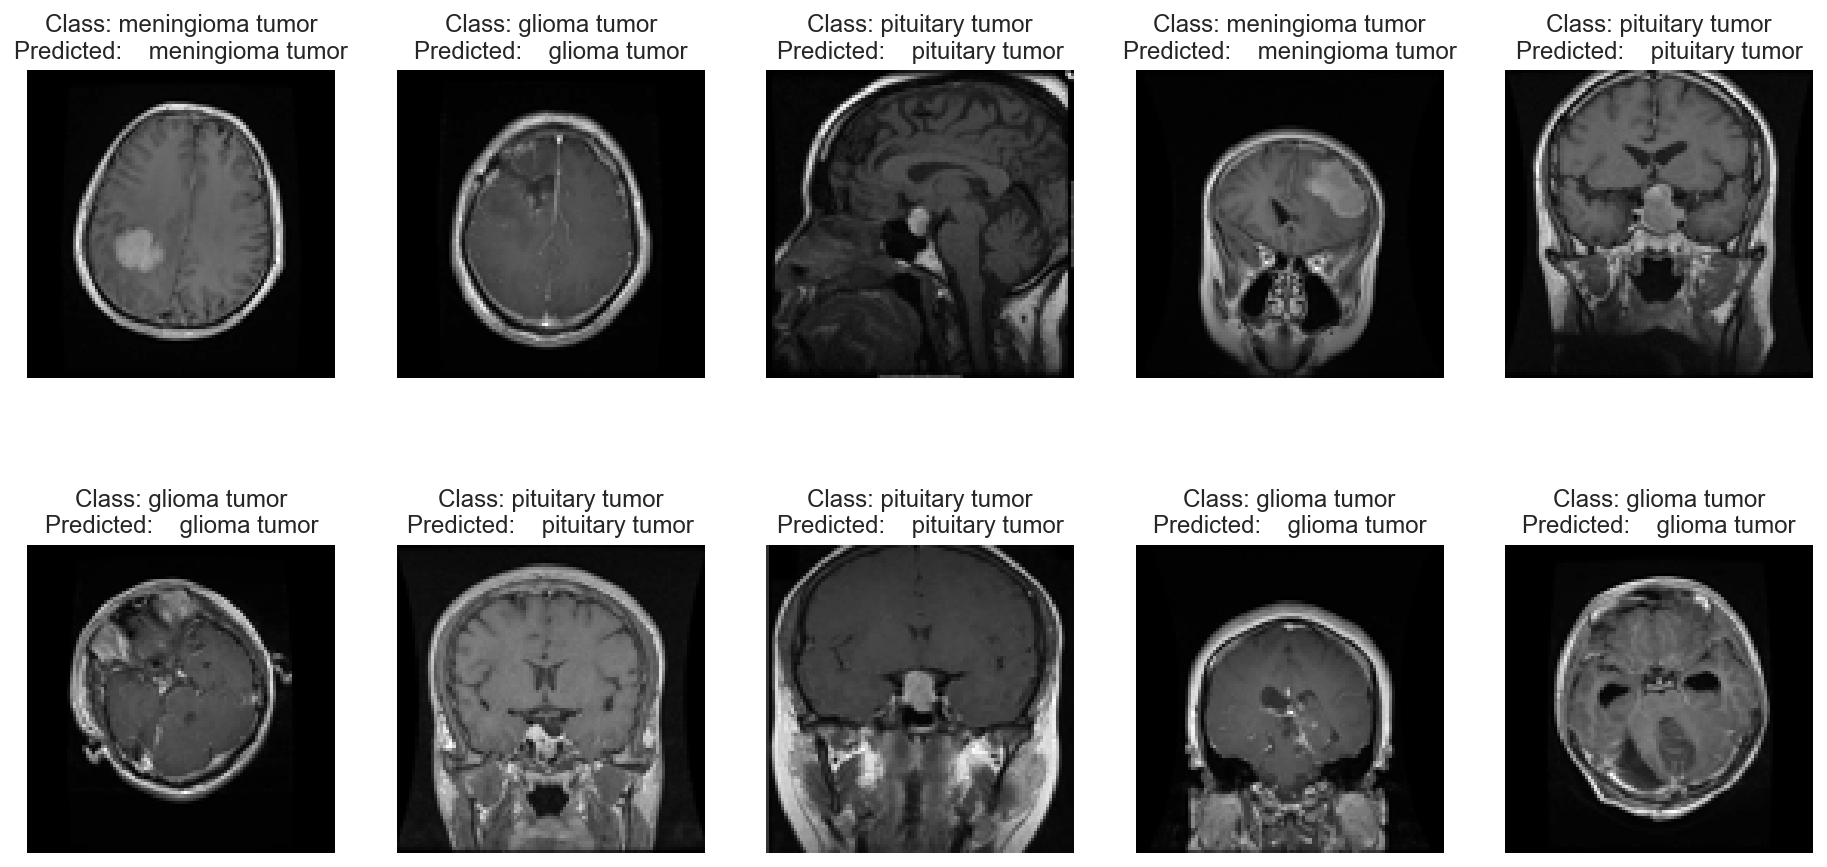

Loss function:  0.68
Accuracy:  0.90


In [25]:
scores = model_CNN.evaluate(X_test, Y_test, verbose=0)

predictions = model_CNN.predict(X_test)

plot_predictions(X_test,Y_test,classes,predictions,scores)

## Conclusioni

In conclusione, nel lavoro presentato sono state implementate due reti neurali (*feed foreward* e convoluzionale) allenate per individuare tumori cerebrali e riconoscerne la tipologia. Le immagini analizzate hanno dimensione $100\times100$ pixel e sono in scala di grigi. Il dataset è stato così suddiviso:

| Campione    | Dimenisone | Percentuale |
|:------------|:----------:|:-----------:|
| Allenamento | 2357       | 72%         |
| Validazione | 490        | 15%         |
| Test        | 417        | 13%         |

Gli elementi delle diverse classi sono stati ridistribuiti nei tre campioni in maniera uniforme, come si può osservare dagli istogrammi riportati in ***Caratteristiche del dataset***.

Infine, riassumiamo le prestazioni delle due reti. 

| Rete                    | Epoche | Tempo  | Accuratezza di test | Funzione di costo (test) |
|:------------------------|:------:|:------:|:-------------------:|:------------------------:|
| *Feed foreward* con PCA | 80     | 100 s  | 87%                 |0.64                      |
| Convoluzionale          | 35     | 29 min | 90%                 |0.68                      |

La prima differenza che emerge dal confronto tre le due reti implementate è che entrambe raggiungono un livello di performance simile, ma con un numero di epoche molto differente. Tuttavia, la prima rete un modello più semplice e computazionalmente più leggero; pertanto, in termini di tempo necessario per l'allenamento è nettamente superiore alla seconda. Inoltre è migliore anche per quanto riguarda la funzione di costo. La seconda rete, tuttavia, ha il pregio di apprendere molto velocemente e di raggiungere una performance comunque migliore. 

Per la tipologia di problema a cui si vuole fare fronte tramite queste reti (riconoscimento di tumori cerebrali) prediligiamo la performance in termini di massimizzazione dell'accuratezza.